# Library

In [2]:
!pip3 list

Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.1.0          
asgiref                  3.2.10         
astor                    0.8.1          
astropy                  4.0.1.post1    
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.4.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.2.0          
beautifulsoup4           4.6.3          
bleach                   3.1.5          
blis                     0.4.1          
bokeh                    1.4.0          
boto                     2.49.0         
boto3                    1.14.9         
botocore                 1.17.9         
Bottleneck      

In [1]:
!pip install Keras==2.2.4

     |████████████████████████████████| 317kB 7.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np
import os, sys
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,LearningRateScheduler, ModelCheckpoint
import math
from keras.layers.merge import concatenate
from keras.regularizers import l2
#from scipy.misc import imread, imresize

Using TensorFlow backend.


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/GoogleNet

/content/drive/My Drive/Colab Notebooks/GoogleNet


# Model

In [ ]:
def inception_model(input, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    conv_1x1 = Conv2D(filters=filters_1x1, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input)

    conv_3x3_reduce = Conv2D(filters=filters_3x3_reduce, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input)

    conv_3x3 = Conv2D(filters=filters_3x3, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(conv_3x3_reduce)

    conv_5x5_reduce  = Conv2D(filters=filters_5x5_reduce, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input)

    conv_5x5 = Conv2D(filters=filters_5x5, kernel_size=(5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.01))(conv_5x5_reduce)

    maxpool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input)

    maxpool_proj = Conv2D(filters=filters_pool_proj, kernel_size=(1, 1), strides=(1, 1), 
                          padding='same', activation='relu', kernel_regularizer=l2(0.01))(maxpool)

    inception_output = concatenate([conv_1x1, conv_3x3, conv_5x5, maxpool_proj], axis=3)  # use tf as backend

    return inception_output

def GoogleNet(weight_path = None):
    input = Input(shape=(224, 224, 3))

    conv1_7x7_s2 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input)

    maxpool1_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1_7x7_s2)

    conv2_3x3_reduce = Conv2D(filters=64, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(maxpool1_3x3_s2)

    conv2_3x3 = Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(conv2_3x3_reduce)

    maxpool2_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2_3x3)

    inception_3a = inception_model(input=maxpool2_3x3_s2, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)

    inception_3b = inception_model(input=inception_3a, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)

    maxpool3_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(inception_3b)

    inception_4a = inception_model(input=maxpool3_3x3_s2, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64)

    inception_4b = inception_model(input=inception_4a, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)

    inception_4c = inception_model(input=inception_4b, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)

    inception_4d = inception_model(input=inception_4c, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64)

    inception_4e = inception_model(input=inception_4d, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)

    maxpool4_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(inception_4e)

    inception_5a = inception_model(input=maxpool4_3x3_s2, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)

    inception_5b = inception_model(input=inception_5a, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128)

    averagepool1_7x7_s1 = AveragePooling2D(pool_size=(7, 7), strides=(7, 7), padding='same')(inception_5b)

    drop1 = Dropout(rate=0.4)(averagepool1_7x7_s1)

    linear = Dense(units=6, activation='softmax', kernel_regularizer=l2(0.01))(keras.layers.core.Flatten()(drop1))
    last = linear

    model = Model(inputs=input, outputs=last)

    return model

In [ ]:
model = GoogleNet()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 56, 56, 64)   4160        max_pooling2d_1[0][0]            
_________

# Modify input

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Dataset/BIT-Vehicle/VehicleInfo.csv', index_col=0)
df

,Name,Height,Width,nVehicle,Left,Top,Right,Bottom,Vehicle_Type
NaN,vehicle_0000001.jpg,1080,1920,1,597,3,935,341,SUV
NaN,vehicle_0000002.jpg,1080,1920,1,399,283,875,874,SUV
NaN,vehicle_0000003.jpg,1080,1920,1,597,97,970,538,SUV
NaN,vehicle_0000004.jpg,1080,1920,1,671,5,978,308,Sedan
NaN,vehicle_0000005.jpg,1080,1920,1,502,341,927,844,Sedan
...,...,...,...,...,...,...,...,...,...
NaN,vehicle_0009846.jpg,1200,1600,1,487,1,1250,720,Truck
NaN,vehicle_0009847.jpg,1200,1600,1,391,1,1144,751,Truck
NaN,vehicle_0009848.jpg,1200,1600,1,414,1,1155,692,Truck
NaN,vehicle_0009849.jpg,1200,1600,1,466,1,1253,717,Truck


In [ ]:
X_list = []

for index, row in df.iterrows():
  print(row['Name'])
  img = image.load_img(Path('/content/drive/My Drive/Dataset/BIT-Vehicle/BITVehicle_Dataset', row['Name']))
  im2array = image.img_to_array(img)
  im = im2array[row['Top']:row['Bottom'],row['Left']:row['Right']] #Top:Bottom,Left:Right
  im_final = image.array_to_img(im).resize((224,224))
  X_list.append(image.img_to_array(im_final))

X = np.array(X_list)
np.save('X',X)

Streaming output truncated to the last 5000 lines.
vehicle_0004852.jpg
vehicle_0004853.jpg
vehicle_0004854.jpg
vehicle_0004855.jpg
vehicle_0004856.jpg
vehicle_0004857.jpg
vehicle_0004858.jpg
vehicle_0004859.jpg
vehicle_0004860.jpg
vehicle_0004861.jpg
vehicle_0004862.jpg
vehicle_0004863.jpg
vehicle_0004864.jpg
vehicle_0004865.jpg
vehicle_0004866.jpg
vehicle_0004867.jpg
vehicle_0004868.jpg
vehicle_0004869.jpg
vehicle_0004870.jpg
vehicle_0004871.jpg
vehicle_0004872.jpg
vehicle_0004873.jpg
vehicle_0004874.jpg
vehicle_0004875.jpg
vehicle_0004876.jpg
vehicle_0004877.jpg
vehicle_0004878.jpg
vehicle_0004879.jpg
vehicle_0004880.jpg
vehicle_0004881.jpg
vehicle_0004882.jpg
vehicle_0004883.jpg
vehicle_0004884.jpg
vehicle_0004885.jpg
vehicle_0004886.jpg
vehicle_0004887.jpg
vehicle_0004888.jpg
vehicle_0004889.jpg
vehicle_0004890.jpg
vehicle_0004891.jpg
vehicle_0004892.jpg
vehicle_0004893.jpg
vehicle_0004894.jpg
vehicle_0004895.jpg
vehicle_0004896.jpg
vehicle_0004897.jpg
vehicle_0004898.jpg
vehicle_0

In [ ]:
df_dummy = pd.get_dummies(df['Vehicle_Type'])
Y = np.array(df_dummy)
np.save('Y',Y)
Y.shape

(9850, 6)

In [ ]:
X = np.load('X.npy')
Y = np.load('Y.npy')

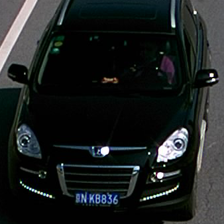

In [ ]:
image.array_to_img(X[0])

In [ ]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=02.)
print(X_Train.shape, Y_Train.shape)
print(X_Test.shape, Y_Test.shape)

In [ ]:
np.save('X_Train',X_Train)
np.save('X_Test',X_Test)
np.save('Y_Train',Y_Train)
np.save('Y_Test',Y_Test)

In [ ]:
X_Train = np.load('X_Train.npy')
X_Test = np.load('X_Test.npy')
Y_Train = np.load('Y_Train.npy')
Y_Test = np.load('Y_Test.npy')

# Training

In [ ]:
model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr=0.001,decay=1e-4,momentum=0.9),
                  metrics=['accuracy'])

In [ ]:
early_Stopping = EarlyStopping(
    monitor='val_loss', 
    #monitor='val_accuracy', 
    patience=5, 
    verbose=1, 
    mode='auto'
)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
checkpointer = ModelCheckpoint(filepath="GoogleNet.hdf5", verbose=1, save_best_only = True, monitor='val_loss')
csv = CSVLogger('GoogleNet.csv', append=True)

In [ ]:
model = load_model('GoogleNet.hdf5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.





In [ ]:
history = model.fit(X_Train, Y_Train,
                       batch_size=64,
                       epochs=100,
                       verbose=1,
                       validation_data=(X_Test, Y_Test),
                       shuffle=True,
                       callbacks=[early_Stopping,reduceLR,checkpointer,csv])

Train on 7880 samples, validate on 1970 samples
Epoch 1/100
7880/7880 [==============================] - 2021s 256ms/step - loss: 3.6105 - accuracy: 0.9376 - val_loss: 3.6639 - val_accuracy: 0.9137

Epoch 00001: val_loss improved from inf to 3.66395, saving model to GoogleNet.hdf5
Epoch 2/100
7880/7880 [==============================] - 2018s 256ms/step - loss: 3.6031 - accuracy: 0.9405 - val_loss: 3.6642 - val_accuracy: 0.9081

Epoch 00002: val_loss did not improve from 3.66395
Epoch 3/100
7880/7880 [==============================] - 2018s 256ms/step - loss: 3.5965 - accuracy: 0.9357 - val_loss: 3.6598 - val_accuracy: 0.9091

Epoch 00003: val_loss improved from 3.66395 to 3.65983, saving model to GoogleNet.hdf5
Epoch 4/100
7880/7880 [==============================] - 2022s 257ms/step - loss: 3.5901 - accuracy: 0.9376 - val_loss: 3.6414 - val_accuracy: 0.9112

Epoch 00004: val_loss improved from 3.65983 to 3.64138, saving model to GoogleNet.hdf5
Epoch 5/100
7880/7880 [=================

# Evaluate score

In [ ]:
score = model.evaluate(X_Test, Y_Test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1970/1970 [==============================] - 117s 59ms/step
Test loss: 3.538928970346596
Test accuracy: 0.9121827483177185


In [ ]:
score = model.evaluate(X, Y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

9850/9850 [==============================] - 583s 59ms/step
Test loss: 3.487586523482037
Test accuracy: 0.9391878247261047


In [ ]:
rs = np.zeros((6,6), dtype=int)
noClass = np.zeros(6, dtype=int)

for i in range (0, 9850):
  predict = model.predict(np.reshape(X[i], (1,224,224,3)))[0].tolist()
  predict = predict.index(max(predict))
  realClass = np.where(Y[i] == 1)[0][0]

  rs[predict][realClass] = rs[predict][realClass] + 1
  noClass[realClass] = noClass[realClass] + 1

print(rs)
print(noClass)

[[ 510    5    8    0    2   18]
 [   2  751   26   42   24    0]
 [  17   14  346    2    3   45]
 [   4   57   10 1224   77    5]
 [   2   32    3  102 5668    0]
 [  20    1   74    2    2  752]]
[ 555  860  467 1372 5776  820]


# Diagram

In [ ]:
import seaborn as sns
from IPython.display import display
%matplotlib inline

In [ ]:
df = pd.read_csv('GoogleNet.csv', index_col='epoch')
df

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.582487,81.805839,0.001,0.577665,79.739135
1,0.601015,77.753397,0.001,0.644670,75.795088
2,0.669670,73.940352,0.001,0.704061,72.071244
3,0.725888,70.394703,0.001,0.764975,68.643944
4,0.763452,67.083948,0.001,0.781218,65.486666
...,...,...,...,...,...
67,0.925761,4.115087,0.001,0.828934,4.295880
68,0.917640,4.052082,0.001,0.880711,4.126990
69,0.921066,3.978067,0.001,0.905076,3.973944


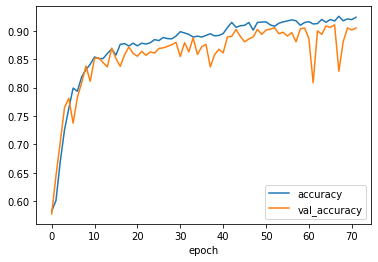

In [ ]:
display(df[['accuracy', 'val_accuracy']].plot())

# Continue training

In [3]:
model = load_model('/content/drive/My Drive/Colab Notebooks/GoogleNet/GoogleNet.hdf5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.





In [ ]:
save_folder = "/content/drive/My Drive/Colab Notebooks/GoogleNet/"
# Save model architecture
model_json = model.to_json()
with open(os.path.join(save_folder,"model.json"), "w") as json_file:
  json_file.write(model_json)
# Save model weight
model.save_weights(os.path.join(save_folder,'model_weight.h5'))

In [7]:
save_folder = "/content/drive/My Drive/Colab Notebooks/GoogleNet/"

In [8]:
with open(os.path.join(save_folder,"model.json"), "r") as json_file:
  model_json = json_file.read()
  model = model_from_json(model_json)

In [9]:
model.load_weights(os.path.join(save_folder,'model_weight.h5'))

In [6]:
model.optimizer.get_config()

{'decay': 9.999999747378752e-05,
 'learning_rate': 0.00010000000474974513,
 'momentum': 0.8999999761581421,
 'nesterov': False}

In [11]:
model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr=0.001,decay=1e-4,momentum=0.9),
                  metrics=['accuracy'])

In [ ]:
X_train = np.load('/content/drive/My Drive/Colab Notebooks/GoogleNet/X_Train.npy')
X_test = np.load('/content/drive/My Drive/Colab Notebooks/GoogleNet/X_Test.npy')
Y_train = np.load('/content/drive/My Drive/Colab Notebooks/GoogleNet/Y_Train.npy')
Y_test = np.load('/content/drive/My Drive/Colab Notebooks/GoogleNet/Y_Test.npy')

In [ ]:
model.layers

In [ ]:
model_extract_feature = Model(model.input, model.get_layer(model.layers[-2].name).output)

In [ ]:
X_train_feats = model_extract_feature.predict(X_train)
X_test_feats = model_extract_feature.predict(X_test)

In [ ]:
X_train_feats = [X_train_feats[i].flatten() for i in range(len(X_train_feats))]
X_test_feats = [X_test_feats[i].flatten() for i in range(len(X_test_feats))]

In [ ]:
Y_train_labels = [np.argmax(Y_train[i]) for i in range(len(Y_train))]
Y_test_labels = [np.argmax(Y_test[i]) for i in range(len(Y_test))]

In [ ]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## SVM

In [ ]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'],
                'gamma': [1e-3, 1e-4, 1e-5],
                'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [ ]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(probability=True), params_grid, cv=5)
svm_model.fit(X_train_feats, Y_train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.001, 0.0001, 1e-05], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
final_model = svm_model.best_estimator_

In [ ]:
Y_pred = final_model.predict(X_test_feats)

In [ ]:
accuracy_score(Y_test_labels,Y_pred)

0.9223350253807107

In [ ]:
from sklearn.externals import joblib
joblib.dump(final_model, "/content/drive/My Drive/Colab Notebooks/GoogleNet/SVMmodelRe.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/content/drive/My Drive/Colab Notebooks/GoogleNet/SVMmodelRe.pkl']

In [ ]:
# from sklearn.externals import joblib
# clf = joblib.load('/content/drive/My Drive/Colab Notebooks/GoogleNet/SVMmodel.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## KNN

In [ ]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'n_neighbors': [7, 20, 100],
                'weights': ['uniform', 'distance']}]
#{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}

In [ ]:
# Performing CV to tune parameters for best SVM fit 
knn_model = GridSearchCV(KNeighborsClassifier(), params_grid, cv=5)
knn_model.fit(X_train_feats, Y_train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [7, 20, 100],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
final_model = knn_model.best_estimator_

In [ ]:
print(final_model.n_neighbors)
print(final_model.weights)

7
distance


In [ ]:
Y_pred = final_model.predict(X_test_feats)

In [ ]:
accuracy_score(Y_test_labels,Y_pred)

0.9203045685279188

In [ ]:
from sklearn.externals import joblib
joblib.dump(final_model, "/content/drive/My Drive/Colab Notebooks/GoogleNet/knn_Flatten_layer.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/content/drive/My Drive/Colab Notebooks/GoogleNet/knn_Flatten_layer.pkl']

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'n_estimators': [10, 20, 50, 100],
                'criterion': ['gini', 'entropy']}]
#{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}

In [ ]:
# Performing CV to tune parameters for best SVM fit 
rf_model = GridSearchCV(RandomForestClassifier(), params_grid, cv=5)
rf_model.fit(X_train_feats, Y_train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
final_model = rf_model.best_estimator_

In [ ]:
print(final_model.n_estimators)
print(final_model.criterion)

50
entropy


In [ ]:
Y_pred = final_model.predict(X_test_feats)

In [ ]:
accuracy_score(Y_test_labels,Y_pred)

0.9213197969543148

In [ ]:
from sklearn.externals import joblib
joblib.dump(final_model, "/content/drive/My Drive/Colab Notebooks/GoogleNet/RandomForest_Flatten_layer.pkl")

['/content/drive/My Drive/Colab Notebooks/GoogleNet/RandomForest_Flatten_layer.pkl']

## KMeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'n_clusters': [6],
                'n_init': [10, 50, 100],
                'max_iter': [100, 200, 300, 500, 1000],
                'tol': [1e-3, 1e-4, 1e-5],
                'algorithm': ['auto', 'full', 'elkan']}]
#{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}

In [ ]:
# Performing CV to tune parameters for best SVM fit 
kmeans_model = GridSearchCV(KMeans(), params_grid, cv=5)
kmeans_model.fit(X_train_feats, Y_train_labels)

In [ ]:
final_model = kmeans_model.best_estimator_

In [ ]:
print(final_model.n_clusters)
print(final_model.n_init)
print(final_model.max_iter)
print(final_model.tol)
print(final_model.algorithm)

In [ ]:
Y_pred = final_model.predict(X_test_feats)

In [ ]:
accuracy_score(Y_test_labels,Y_pred)

In [ ]:
from sklearn.externals import joblib
joblib.dump(final_model, "/content/drive/My Drive/Colab Notebooks/GoogleNet/KMeans_Flatten_layer.pkl")

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'alpha': [0, 1, 1e-2, 1e-3, 1e-4, 1e-5],
                'fit_prior': [True, False],
                'class_prior': [100, 200, 300, 500, 1000]}]
#{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}

In [ ]:
# Performing CV to tune parameters for best SVM fit 
MNB_model = GridSearchCV(MultinomialNB(), params_grid, cv=5)
MNB_model.fit(X_train_feats, Y_train_labels)

In [ ]:
final_model = MNB_model.best_estimator_

In [ ]:
print(final_model.alpha)
print(final_model.fit_prior)
print(final_model.class_prior)

In [ ]:
Y_pred = final_model.predict(X_test_feats)

In [ ]:
accuracy_score(Y_test_labels,Y_pred)

In [ ]:
from sklearn.externals import joblib
joblib.dump(final_model, "/content/drive/My Drive/Colab Notebooks/GoogleNet/MNB_Flatten_layer.pkl")